<a href="https://colab.research.google.com/github/matsunagalab/ColabBTR/blob/main/ColabBTR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##ColabBTR: Blind tip reconstruction on Google Colab

Easy to use notebook for using the end-to-end differentiable blind tip reconstruction and removing the tip convolution artifacts from your AFM data.

* This notebook can read and write several file formats of AFM data
* Performs the end-to-end differentiable blind tip reconsruction to reconstruct tip shape only from AFM data
* Performs erosion (deconvoulution) with the reconstructed tip to remove tip convolution artifacts

[Y. Matsunaga, S. Fuchigami, T. Ogane, S. Takada. End-to-end differentiable blind tip reconstruction for noisy atomic force microscopy images.
*Scientific Reports*, 2023](https://www.nature.com/articles/s41598-022-27057-2)

In [1]:
#@title Install dependencies
%%time
import os

print("installing colabbtr...")
os.system("pip install -q --no-warn-conflicts git+https://github.com/matsunagalab/ColabBTR")

#print("installing libasd...")
#os.system("pip install -q --no-warn-conflicts libasd")

print("upgrading gdown...")
os.system("pip install -q --upgrade --no-warn-conflicts gdown")

print("installing spmpy...")
os.system("pip install -q --no-warn-conflicts git+https://github.com/kogens/spmpy")

print("installing gwyfile...")
os.system("pip install -q --no-warn-conflicts gwyfile")

print("✨All installation completed!✨")


installing colabbtr...
upgrading gdown...
installing spmpy...
installing gwyfile...
✨All installation completed!✨
CPU times: user 5.63 ms, sys: 1.1 ms, total: 6.73 ms
Wall time: 22.1 s


In [2]:
#@title Upload AFM data (npy, npz, csv, gwy, spm files)
try:
    from google.colab import files
except ImportError:
    files = None
import urllib.request
import os

def upload_and_move_file(upload_path: str) -> str:
    """Upload a single file and move it to the specified path."""
    if files is not None:
        # Google Colabでのファイルアップロード
        uploaded = files.upload()
        if len(uploaded) != 1:
            raise ValueError("Please upload exactly one file.")
        filename = list(uploaded.keys())[0]
    else:
        # ローカル環境でのファイル指定
        filename = input("Enter the path of the file to upload: ")
        if not os.path.isfile(filename):
            raise ValueError("The specified file does not exist.")

    destination = os.path.join(upload_path, os.path.basename(filename))
    os.rename(filename, destination)
    return destination

def upload_default_file(upload_path: str) -> str:
    """Upload a default file and move it to the jobname folder."""
    url = "https://github.com/matsunagalab/ColabBTR/raw/refs/heads/main/data/double_tip/images.npy"
    filename = "images.npy"
    urllib.request.urlretrieve(url, filename)
    destination = os.path.join(upload_path, filename)
    os.rename(filename, destination)
    return destination

#@markdown - If you just want to try blind tip reconstruction, enable `use_example` below. It will automatically download a demo AFM dataset (artificially generated pseudo AFM images with a double tip shape).
use_example = True #@param {type:"boolean"}
#@markdown - **Jobname**: just for name of the folder where data is uploaded
jobname = 'test' #@param {type:"string"}
#@markdown Click the button that will appears below this cell to upload your AFM file.
resolution_x = 1
resolution_y = 1

try:
    # Create job directory
    custom_path = os.path.join(jobname, "afm_data")
    os.makedirs(custom_path, exist_ok=True)

    # Upload and move file
    if use_example:
        file_path = upload_default_file(custom_path)
    else:
        file_path = upload_and_move_file(custom_path)

    print(f"Job name: {jobname}")
    print(f"Upload path: {custom_path}")
    print(f"Uploaded file path: {file_path}")
    print(f"Resolution: {resolution_x}x{resolution_y}")

    # Save metadata
    metadata_path = os.path.join(custom_path, "metadata.txt")
    with open(metadata_path, "w") as f:
        f.write(f"Job name: {jobname}\n")
        f.write(f"Resolution: {resolution_x}x{resolution_y}\n")
        f.write(f"Uploaded file path: {file_path}\n")

except Exception as e:
    print(f"An error occurred: {str(e)}")

Job name: test
Upload path: test/afm_data
Uploaded file path: test/afm_data/images.npy
Resolution: 1x1


In [3]:
#@title Load the uploaded data
import torch
#import libasd
import numpy as np
import matplotlib.pyplot as plt
import gwyfile
import os

#@markdown - **Frame range**: frames used for subsequent analysis (`nframe` means the last frame in the data. Recommended to use several frames or several tens of frames for blind tip reconstruction)
nframe = -1
first_frame = 0#@param {type:"raw"}
last_frame = 30#@param {type:"raw"}
#@markdown - **Channel number** (option for 2ch *.asd* file. 0 or 1)<br>
#@markdown example: 0
channel_number_in_asd = 0#@param {type:"raw"}
#@markdown - **Name of channels** (option for *.gwy* file)<br>
#@markdown example: topography
channel_name_in_gwyfile = "topography"#@param {type:"string"}

# Save parameter file
custom_path = os.path.join(jobname, 'afm_data')
os.makedirs(custom_path, exist_ok=True)

with open(os.path.join(custom_path, 'upload_file_params.txt'), 'w') as f:
    f.write(f'channel_number_in_asd: {channel_number_in_asd}\n')
    f.write(f'channel_name_in_gwyfile: {channel_name_in_gwyfile}\n')

def load_asd_file(file_path, channel_number=0):
    data = libasd.read_asd(file_path)
    print(f"ASD file version: {data.header.file_version}")

    is_channel = False
    if hasattr(data, 'channels'):
        is_channel = True

    if is_channel:
        channel = data.channels[channel_number]
        nframe = len(channel)
        images = np.array([frame.image() for frame in channel])
    else:
        nframe = len(data.frames)
        images = np.array([frame.image() for frame in data.frames])

    return images

def load_gwy_file(file_path, channel_name):
    obj = gwyfile.load(file_path)
    channels = gwyfile.util.get_datafields(obj)
    channel = channels[channel_name]
    return np.expand_dims(channel.data, axis=0)

def load_numpy_file(file_path):
    return np.load(file_path)

# Dictionary mapping file extensions to their respective loading functions
loaders = {
    '.asd': load_asd_file,
    '.gwy': load_gwy_file,
    '.npy': load_numpy_file,
    '.npz': load_numpy_file
}

# Load the data
file_extension = os.path.splitext(file_path)[-1].lower()

if file_extension not in loaders:
    raise ValueError(f"Unsupported file type: {file_extension}")

loader_func = loaders[file_extension]
if file_extension == '.asd':
    images = loader_func(file_path, channel_number_in_asd)
elif file_extension == '.gwy':
    images = loader_func(file_path, channel_name_in_gwyfile)
else:
    images = loader_func(file_path)

# Create tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
images = torch.tensor(images, dtype=torch.float32, device=device)
nframe = images.shape[0]

# extract subframes
if last_frame < 0:
    last_frame = nframe
images = images[first_frame:last_frame, :, :]

# Display information
print(f"Loaded file: {file_path}")
print(f"Image shape: {images.shape}")
print(f"Number of frames: {nframe}")
print(f"Pixel height: {images.shape[1]}")
print(f"Pixel width: {images.shape[2]}")

# Optional: Save the loaded data in numpy format
np.save(os.path.join(custom_path, 'loaded_images.npy'), images.cpu().numpy())

Loaded file: test/afm_data/images.npy
Image shape: torch.Size([30, 30, 30])
Number of frames: 576
Pixel height: 30
Pixel width: 30


In [4]:
#@title Visualize the data
# from google.colab import output
# output.enable_custom_widget_manager()
import plotly.graph_objects as go
import os

first_frame = 0
nframe = images.shape[0]
last_frame = nframe

vmin = images.min().item()
vmax = images.max().item()

figsize = 600

fps = 30

# Convert to NumPy array
images_np = images.cpu().numpy()

# Visualize by plotly
fig = go.Figure()

# plot 1st frame
fig.add_trace(
    go.Heatmap(
        z=images_np[first_frame],
        zmin=vmin,
        zmax=vmax,
        colorscale='Hot',
        colorbar=dict(title='Height')  # 最初の1枚にだけカラーバーを付ける
    )
)

# create frame for animation
frames = []
for i in range(first_frame, last_frame):
    frames.append(
        go.Frame(
            data=[
                go.Heatmap(
                    z=images_np[i],
                    zmin=vmin,
                    zmax=vmax,
                    colorscale='Hot',
                    # 2 枚目以降はカラーバーを表示しないでも OK
                    # colorbar=dict(title='Height')
                )
            ],
            name=f"frame_{i}",
            layout=go.Layout(title=f'AFM Image Visualization - Frame {i}')
        )
    )

# create layout
fig.update_layout(
    title=f'AFM Image Visualization - Frame {first_frame}',
    width=figsize,
    height=figsize,
    xaxis_title='X',
    yaxis_title='Y',
    # updatemenus: Play/Pause button
    updatemenus=[
        {
            "type": "buttons",
            "showactive": True,
            "buttons": [
                {
                    "label": "Play",
                    "method": "animate",
                    "args": [None, {
                        "frame": {"duration": 1000 / fps, "redraw": True},
                        "fromcurrent": True,
                        "transition": {"duration": 0}
                    }],
                },
                {
                    "label": "Pause",
                    "method": "animate",
                    "args": [[None], {
                        "frame": {"duration": 0, "redraw": False},
                        "mode": "immediate",
                        "transition": {"duration": 0}
                    }],
                }
            ],
        }
    ],
    # sliders
    sliders=[{
        "active": first_frame,
        "currentvalue": {"prefix": "Frame: "},
        "pad": {"t": 50},
        "steps": [
            {
                "label": str(i),
                "method": "animate",
                "args": [[f"frame_{i}"], {
                    "frame": {"duration": 0, "redraw": True},
                    "mode": "immediate",
                    "transition": {"duration": 0}
                }]
            }
            for i in range(first_frame, last_frame)
        ]
    }]
)

fig.frames = frames
fig.show()

In [5]:
#@title (Optional) Correct stage tilt by RANSAC

import os
import torch
import numpy as np
from sklearn.linear_model import RANSACRegressor
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# -- もし Google Colab でカスタムウィジェットマネージャが必要なら --
# from google.colab import output
# output.enable_custom_widget_manager()

# subtract z_mean for each image
def preprocess_subtract_mean_z_per_frame(images):
    """
    images: torch.Tensor of shape (nframes, height, width)
    Returns:
        preprocessed_images: torch.Tensor, same shape as images
    """
    # PyTorch → NumPy へ変換
    np_images = images.cpu().numpy()  # shape: (nframes, height, width)
    nframes, height, width = np_images.shape

    # 各フレームごとに平均を計算し、その平均分を引く
    for i in range(nframes):
        mean_z = np_images[i].mean()
        np_images[i] -= mean_z

    # NumPy → PyTorch へ戻す
    preprocessed_images = torch.tensor(
        np_images, dtype=images.dtype, device=images.device
    )
    return preprocessed_images

# correct tilt by RANSAC
def correct_afm_tilt_multi_frame(images):
    np_images = images.cpu().numpy()

    # Create (x, y, z) coordinates for all frames combined
    nframes, height, width = np_images.shape
    y_grid, x_grid = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')
    coordinates = np.stack([np.repeat(x_grid.ravel(), nframes),
                            np.repeat(y_grid.ravel(), nframes),
                            np_images.reshape(-1)], axis=1)

    # Perform plane fitting using RANSAC for all frames combined
    ransac = RANSACRegressor()
    ransac.fit(coordinates[:, :2], coordinates[:, 2])

    # Get parameters of the plane (ax + by + c = z)
    a, b = ransac.estimator_.coef_
    c = ransac.estimator_.intercept_

    # Calculate corrected heights for all frames
    corrected_images = np_images - (a * x_grid + b * y_grid + c)

    # Identify inliers and outliers for all frames
    inlier_mask = ransac.inlier_mask_.reshape(nframes, height, width)

    # Convert corrected_images and inlier_mask back to PyTorch tensors
    corrected_images_tensor = torch.tensor(
        corrected_images, dtype=images.dtype, device=images.device
    )
    inlier_mask_tensor = torch.tensor(
        inlier_mask, dtype=torch.float32, device=images.device
    )

    return corrected_images_tensor, inlier_mask_tensor

# preprocess (subtract z-mean for each image)
images = preprocess_subtract_mean_z_per_frame(images)

# perform RANSAC
corrected_images, inlier_mask = correct_afm_tilt_multi_frame(images)

# save information
custom_path = os.path.join(jobname, 'stage_tilt')
os.makedirs(custom_path, exist_ok=True)
np.save(f'{custom_path}/corrected_images', corrected_images.cpu().numpy())
np.save(f'{custom_path}/inlier_mask', inlier_mask.cpu().numpy())

# will use images for the subsequent analysis
images = corrected_images

nframe = images.shape[0]

first_frame = 0
last_frame = nframe

vmin = images.min().item()
vmax = images.max().item()

figsize = 600

# save parameters
with open(f'{custom_path}/stage_tilt_params.txt', 'w') as f:
    f.write(f'first_frame: {first_frame}\n')
    f.write(f'last_frame: {last_frame}\n')
    f.write(f'vmin: {vmin}\n')
    f.write(f'vmax: {vmax}\n')
    f.write(f'figsize: {figsize}\n')

# Visualize by Plotly

# Converto to NumPy array
images_np = images.cpu().numpy()
inlier_np = inlier_mask.cpu().numpy()

# subplot (1 row, 2 columns)
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Corrected Image', 'Inlier Mask')
)

# plot 1st frame (Trace 0: corrected image, Trace 1: inlier mask)
fig.add_trace(
    go.Heatmap(
        z=images_np[first_frame],
        zmin=vmin,
        zmax=vmax,
        colorscale='Hot',
        colorbar=dict(title='Height', x=0.45)  # left-sided colorbar
    ),
    row=1, col=1
)
fig.add_trace(
    go.Heatmap(
        z=inlier_np[first_frame],
        zmin=0,
        zmax=1,
        colorscale=[
            [0, 'rgb(165,0,38)'],    # Outlier: Dark red
            [0.5, 'rgb(255,255,255)'],
            [1, 'rgb(49,54,149)']    # Inlier: Dark blue
        ],
        colorbar=dict(
            title='Inlier/Outlier',
            x=0.98,
            len=0.75,
            tickvals=[0, 0.5, 1],
            ticktext=['Outlier', '', 'Inlier']
        )
    ),
    row=1, col=2
)

# create frames for animation
frames = []
for i in range(first_frame, last_frame):
    frames.append(
        go.Frame(
            data=[
                go.Heatmap(
                    z=images_np[i],
                    zmin=vmin,
                    zmax=vmax,
                    colorscale='Hot'
                ),
                go.Heatmap(
                    z=inlier_np[i],
                    zmin=0,
                    zmax=1,
                    colorscale=[
                        [0, 'rgb(165,0,38)'],
                        [0.5, 'rgb(255,255,255)'],
                        [1, 'rgb(49,54,149)']
                    ]
                )
            ],
            name=f"frame_{i}",
            layout=go.Layout(title=f'RANSAC Tilt Correction - Frame {i}')
        )
    )

#===============================
# Play/Pause Button & Slider
#===============================
# ※ Official document
#    https://plotly.com/python/animations/
#    の「frame アニメーション」と同様の設定です。

fig.update_layout(
    title=f'RANSAC Tilt Correction - Frame {first_frame}',
    width=figsize * 2,   # 2列なので横幅は2倍にしておく
    height=figsize,
    # subplot間の縦横比を一致させる
    xaxis=dict(scaleanchor="y", scaleratio=1),
    yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis2=dict(scaleanchor="y2", scaleratio=1),
    yaxis2=dict(scaleanchor="x2", scaleratio=1),

    # Play/Pause button
    updatemenus=[
        {
            "type": "buttons",
            "showactive": True,
            "buttons": [
                {
                    "label": "Play",
                    "method": "animate",
                    "args": [
                        None,
                        {
                            "frame": {"duration": 100, "redraw": True},
                            "fromcurrent": True,
                            "transition": {"duration": 0}
                        }
                    ],
                },
                {
                    "label": "Pause",
                    "method": "animate",
                    "args": [
                        [None],
                        {
                            "frame": {"duration": 0, "redraw": False},
                            "mode": "immediate",
                            "transition": {"duration": 0}
                        }
                    ],
                }
            ],
        }
    ],

    # Frame forward/reverse slider
    sliders=[{
        "active": 0,
        "currentvalue": {"prefix": "Frame: "},
        "pad": {"t": 50},
        "steps": [
            {
                "label": str(i),
                "method": "animate",
                "args": [
                    [f"frame_{i}"],
                    {
                        "frame": {"duration": 0, "redraw": True},
                        "mode": "immediate",
                        "transition": {"duration": 0}
                    }
                ]
            }
            for i in range(first_frame, last_frame)
        ]
    }]
)

fig.frames = frames
fig.show()

In [ ]:
#@title (Optional) Denoise using Noise2Noise

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from tqdm.notebook import tqdm

try:
    from google.colab import output
    colab_env = True
    output.enable_custom_widget_manager()
except ImportError:
    colab_env = False

# parameters
num_epochs = 100
batch_size = 8
learning_rate = 0.001
num_filters = 64
use_skip_connections = False
use_batch_norm = False

# save information
custom_path = os.path.join(jobname, 'denoising')
os.makedirs(custom_path, exist_ok=True)

# Simple U-Net
class SimpleUNet(nn.Module):
    def __init__(self, num_filters, use_skip_connections, use_batch_norm):
        super(SimpleUNet, self).__init__()
        self.use_skip_connections = use_skip_connections

        # Encoder
        self.enc1 = nn.Conv2d(1, num_filters, 3, padding=1)
        self.enc2 = nn.Conv2d(num_filters, num_filters, 3, padding=1)

        # Decoder
        self.dec1 = nn.ConvTranspose2d(num_filters, num_filters, 3, padding=1)
        self.dec2 = nn.ConvTranspose2d(num_filters, 1, 3, padding=1)

        self.relu = nn.ReLU()

        if use_batch_norm:
            self.bn1 = nn.BatchNorm2d(num_filters)
            self.bn2 = nn.BatchNorm2d(num_filters)
            self.bn3 = nn.BatchNorm2d(num_filters)

    def forward(self, x):
        # Encoding
        e1 = self.relu(self.enc1(x))
        e1 = self.bn1(e1) if hasattr(self, 'bn1') else e1

        e2 = self.relu(self.enc2(e1))
        e2 = self.bn2(e2) if hasattr(self, 'bn2') else e2

        # Decoding
        d1 = self.relu(self.dec1(e2))
        d1 = self.bn3(d1) if hasattr(self, 'bn3') else d1

        if self.use_skip_connections:
            d1 = d1 + e1

        x = self.dec2(d1)
        return x

# Noise2Noise Training
def train_noise2noise(images, num_epochs, batch_size, learning_rate, num_filters, use_skip_connections, use_batch_norm):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Prepare data
    nframes, height, width = images.shape
    # [nframes, height, width] -> [nframes, 1, height, width]
    images = images.unsqueeze(1)

    # Create pairs of adjacent frames (simple approach)
    input_frames = images[:-1]   # All frames except the last one
    target_frames = images[1:]   # All frames except the first one

    dataset = TensorDataset(input_frames, target_frames)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Model
    model = SimpleUNet(num_filters, use_skip_connections, use_batch_norm).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Use tqdm for progress
    epoch_bar = tqdm(range(num_epochs), desc="Training Progress")
    for epoch in epoch_bar:
        model.train()
        running_loss = 0.0
        for input_batch, target_batch in loader:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            optimizer.zero_grad()
            outputs = model(input_batch)
            loss = criterion(outputs, target_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * input_batch.size(0)

        epoch_loss = running_loss / len(loader.dataset)
        epoch_bar.set_postfix({"Epoch Loss": f"{epoch_loss:.4f}"})

    return model

# inference (denoise)
def denoise_images(model, images):
    model.eval()
    with torch.no_grad():
        # model [nframes, 1, H, W]
        # images [nframes, H, W]
        denoised_images = model(images.unsqueeze(1)).squeeze(1)
    return denoised_images

# perform noise2noise denoising
model = train_noise2noise(images, num_epochs, batch_size, learning_rate, num_filters, use_skip_connections, use_batch_norm)
denoised_images = denoise_images(model, images)
noisy_images = images
images = denoised_images

def plot_denoised_animation(original_images, denoised_images):
    # NumPy に変換
    orig_np = original_images.cpu().numpy() if torch.is_tensor(original_images) else original_images
    deno_np = denoised_images.cpu().numpy() if torch.is_tensor(denoised_images) else denoised_images

    nframes = orig_np.shape[0]

    # 全フレームを通じた最小・最大
    global_min = min(orig_np.min(), deno_np.min())
    global_max = max(orig_np.max(), deno_np.max())

    # -- Figure & 初期フレーム --
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=("Original Image", "Denoised Image")
    )

    # Original Image (Left)。Without colorbar: showscale=False
    fig.add_trace(
        go.Heatmap(
            z=orig_np[0],
            zmin=global_min,
            zmax=global_max,
            colorscale='Hot',
            showscale=False  # カラーバー非表示
        ),
        row=1, col=1
    )

    # Denoised Image。カラーバーを表示し、位置を右寄りに
    fig.add_trace(
        go.Heatmap(
            z=deno_np[0],
            zmin=global_min,
            zmax=global_max,
            colorscale='Hot',
            colorbar=dict(
                title="Intensity",
                x=1.0  # 右側に表示 (お好みで微調整)
            )
        ),
        row=1, col=2
    )

    # -- frames をまとめる --
    frames = []
    for i in range(nframes):
        frames.append(
            go.Frame(
                data=[
                    go.Heatmap(
                        z=orig_np[i],
                        zmin=global_min,
                        zmax=global_max,
                        colorscale='Hot',
                        showscale=False  # 左は常にカラーバー無し
                    ),
                    go.Heatmap(
                        z=deno_np[i],
                        zmin=global_min,
                        zmax=global_max,
                        colorscale='Hot',
                        # 右はカラーバーあり
                        colorbar=dict(title="Intensity", x=1.0)
                    ),
                ],
                name=f"frame_{i}",
                layout=go.Layout(
                    title_text=f"Original vs Denoised Image - Frame {i}"
                )
            )
        )

    # -- レイアウト (Play/Pause + スライダー) --
    fig.update_layout(
        title="Original vs Denoised Image - Frame 0",
        width=1000,
        height=600,
        updatemenus=[
            {
                "type": "buttons",
                "showactive": True,
                "buttons": [
                    {
                        "label": "Play",
                        "method": "animate",
                        "args": [
                            None,
                            {
                                "frame": {"duration": 100, "redraw": True},
                                "fromcurrent": True,
                                "transition": {"duration": 0}
                            }
                        ],
                    },
                    {
                        "label": "Pause",
                        "method": "animate",
                        "args": [
                            [None],
                            {
                                "frame": {"duration": 0, "redraw": False},
                                "mode": "immediate",
                                "transition": {"duration": 0}
                            }
                        ],
                    }
                ],
            }
        ],
        sliders=[{
            "active": 0,
            "currentvalue": {"prefix": "Frame: "},
            "pad": {"t": 50},
            "steps": [
                {
                    "label": str(i),
                    "method": "animate",
                    "args": [
                        [f"frame_{i}"],
                        {
                            "frame": {"duration": 0, "redraw": True},
                            "mode": "immediate",
                            "transition": {"duration": 0}
                        }
                    ]
                }
                for i in range(nframes)
            ]
        }]
    )

    # -- フレーム登録 --
    fig.frames = frames

    #  subplotが2つあるので、 xaxis1, xaxis2, yaxis1, yaxis2 に適用
    fig.update_xaxes(
        showgrid=False,       # グリッド線を消す
        showline=True,        # 軸線を表示
        linecolor='black',    # 軸線の色
        ticks='',             # 軸目盛りの「短い線」を消す
        ticklen=0,            # ticklen=0 でもOK
    )
    fig.update_yaxes(
        showgrid=False,
        showline=True,
        linecolor='black',
        ticks='',
        ticklen=0,
    )

    fig.show()

plot_denoised_animation(noisy_images, images)

Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating lambdas: 100%|██████████| 5/5 [05:39<00:00, 67.85s/it]


Suggested optimal lambda: 0.0011


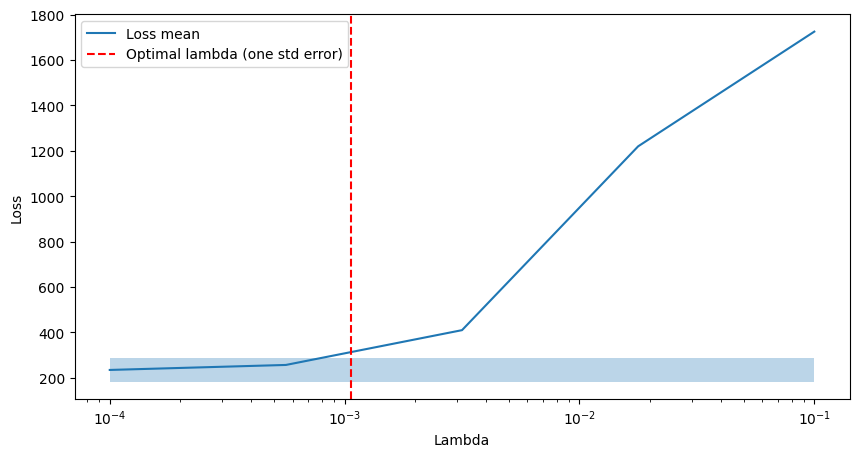

In [6]:
#@title (Optional) Find optimal regularization parameter (lambda) by five-fold cross-validation

#@title Run the end-to-end differentiable BTR and reconstruct tip shape from AFM images

from colabbtr.morphology import differentiable_btr, idilation, ierosion
from tqdm import tqdm
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "colab"

custom_path = os.path.join(jobname, 'differentiable_BTR')
os.makedirs(custom_path, exist_ok=True)

#@markdown - **Lambda range**: lambda values used for finding optimal lambda (the number of `lambda_num` values sampled in the range between `lambda_min` and `lambda_max`)
lambda_min = 0.0001#@param {type:"raw"}
lambda_max = 0.1#@param {type:"raw"}
lambda_num = 5#@param {type:"raw"}
lambdas = np.logspace(np.log10(lambda_min), np.log10(lambda_max), lambda_num)

nframe = images.shape[0]
first_frame = 0
last_frame = nframe

#@markdown - **Tip size**: pixel size used for tip height and width
tip_size = 10#@param {type:"raw"}
tip_height = tip_size
tip_width = tip_size

#@markdown - **Settings for learning**: settings for optimization
learning_rate = 0.1#@param {type:"raw"}
epoch = 200#@param {type:"raw"}

# evaluate loss mean and std by 10-fold cross validation
def evaluate_loss_mean_and_std(images_train, tip_height, tip_width, epoch, learning_rate, lambda1):
    n_samples = last_frame - first_frame
    n_folds = 5
    fold_size = n_samples // n_folds
    CV_loss = []

    for fold in range(n_folds):
        # Calculate validation fold indices
        val_start = fold * fold_size
        val_end = (fold + 1) * fold_size if fold < n_folds - 1 else n_samples

        # Split data into training and validation
        images_train = images[first_frame:last_frame, :, :]

        train_indices = np.concatenate([np.arange(0, val_start), np.arange(val_end, n_samples)])
        val_indices = slice(val_start, val_end)

        train_data = torch.cat([images_train[i:i+1] for i in train_indices], dim=0)
        val_data   = torch.cat([images_train[i:i+1] for i in range(val_start, val_end)], dim=0)

        tip, _ = differentiable_btr(train_data,
                                   (tip_height, tip_width),
                                   nepoch=epoch, lr=learning_rate, weight_decay=lambda1, is_tqdm=False)

        with torch.no_grad():
            val_loss = 0
            for i in range(val_data.shape[0]):
                image = val_data[i, :, :]
                image_reconstructed = idilation(ierosion(image, tip), tip)
                loss_tmp = torch.mean((image_reconstructed - image)**2)
                val_loss += loss_tmp.item()

        CV_loss.append(val_loss)

    return np.mean(CV_loss), np.std(CV_loss)

loss_mean = []
loss_std = []
for lambda1 in tqdm(lambdas, desc='Evaluating lambdas'):
    loss_mean_each, loss_std_each = evaluate_loss_mean_and_std(images, tip_height, tip_width, epoch, learning_rate, lambda1)
    loss_mean.append(loss_mean_each)
    loss_std.append(loss_std_each)

# One standard error ruleにしたがって、最も小さいlossを選択する。
imin = np.argmin(loss_mean)
loss_min_plus_std = loss_mean[imin] + loss_std[imin]
imin_plus_std = np.where(loss_mean <= loss_min_plus_std)[0]
imin_plus_std = np.max(imin_plus_std)

# 線形補間により、loss_min_plus_stdのlossを持つ最も大きなlambdaを探す
lambda_min_plus_std = lambdas[imin_plus_std]
lambda_max_plus_std = lambdas[imin_plus_std + 1]
lambda_min_plus_std = lambda_min_plus_std + (lambda_max_plus_std - lambda_min_plus_std) * (loss_min_plus_std - loss_mean[imin_plus_std]) / (loss_mean[imin_plus_std + 1] - loss_mean[imin_plus_std])

print(f"Suggested optimal lambda: {lambda_min_plus_std:.4f}")

# 結果をプロットする。 loss_meanのプロットと、imin における loss_std の範囲をプロットする。
# さらに、lambda_min_plus_stdの場所を縦線で示す。
plt.figure(figsize=(10, 5))
plt.plot(lambdas, loss_mean, label='Loss mean')
plt.fill_between(lambdas,
                [loss_mean[imin] - loss_std[imin]] * len(lambdas),
                [loss_mean[imin] + loss_std[imin]] * len(lambdas),
                alpha=0.3)
plt.axvline(x=lambda_min_plus_std, color='red', linestyle='--', label='Optimal lambda (one std error)')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [7]:
#@title Run the end-to-end differentiable BTR and reconstruct tip shape from AFM images

from colabbtr.morphology import differentiable_btr
import plotly.graph_objects as go
import plotly.io as pio

try:
    from google.colab import output
    colab_env = True
    output.enable_custom_widget_manager()
    pio.renderers.default = "colab"
except ImportError:
    colab_env = False
    pio.renderers.default = "notebook"  # ローカル環境用のレンダラー設定

custom_path = os.path.join(jobname, 'differentiable_BTR')
os.makedirs(custom_path, exist_ok=True)

nframe = images.shape[0]
first_frame = 0
last_frame = nframe

#@markdown - **Tip size**: pixel size used for tip height and width
tip_size = 10#@param {type:"raw"}
tip_height = tip_size
tip_width = tip_size

#@markdown - **Settings for learning**: setting for optimization including regularizatino parameter lambda
lambda_ = 0.0011#@param {type:"raw"}
learning_rate = 0.1#@param {type:"raw"}
epoch = 200#@param {type:"raw"}

# Save parameter file
with open(f'{custom_path}/differentiable_BTR_params.txt', 'w') as f:
    f.write(f'first_frame: {first_frame}\n')
    f.write(f'last_frame: {last_frame}\n')
    f.write(f'tip_size: {tip_size}\n')
    f.write(f'epoch: {epoch}\n')
    f.write(f'learning_rate: {learning_rate}\n')
    f.write(f'lambda: {lambda_}\n')

tip, loss = differentiable_btr(images[first_frame:last_frame, :, :],
                             (tip_height, tip_width),
                             nepoch=epoch, lr=learning_rate, weight_decay=lambda_)
np.save(f'{custom_path}/tip', tip.to('cpu').numpy())
np.save(f'{custom_path}/loss', loss)

# Plot interactive loss function
fig_loss = go.Figure()
fig_loss.add_trace(go.Scatter(y=loss, mode='lines', name='Loss'))
fig_loss.update_layout(title='Loss function',
                       xaxis_title='Epoch',
                       yaxis_title='Loss',
                       width=800,
                       height=500)
fig_loss.show()

# Plot interactive 3D tip shape
fig_3d = go.Figure(data=[go.Surface(z=tip.to('cpu').numpy())])
fig_3d.update_traces(contours_z=dict(show=True, usecolormap=True,
                                     highlightcolor="limegreen", project_z=True))
fig_3d.update_layout(title='Tip shape 3D', autosize=False,
                     width=600, height=500,
                     margin=dict(l=65, r=50, b=65, t=50))
fig_3d.show()

  0%|          | 0/200 [00:00<?, ?it/s]

In [8]:
#@title Run erosion (deconvolution) with the reconstructed tip

import torch
from colabbtr.morphology import ierosion
import numpy as np
import os

import plotly.graph_objects as go
from plotly.subplots import make_subplots

try:
    from google.colab import output
    colab_env = True
    output.enable_custom_widget_manager()
except ImportError:
    colab_env = False

#-------------------------------------------
# 1. Erosion 計算 (元のコードを流用)
#-------------------------------------------
custom_path = os.path.join(jobname, 'erosion')
os.makedirs(custom_path, exist_ok=True)

surface = torch.zeros_like(images, device=device)
for iframe in range(nframe):
    surface[iframe, :, :] = ierosion(images[iframe, :, :], tip)

np.save(f'{custom_path}/surface', surface.to('cpu').numpy())

nframe = images.shape[0]
first_frame = 0
last_frame = nframe

vmin_surface = surface.min().item()
vmax_surface = surface.max().item()

vmin_images = images.min().item()
vmax_images = images.max().item()

vmin = min(vmin_surface, vmin_images)
vmax = max(vmax_surface, vmax_images)

figsize = 600

# Save parameter file
with open(f'{custom_path}/erosion_params.txt', 'w') as f:
    f.write(f'first_frame: {first_frame}\n')
    f.write(f'last_frame: {last_frame}\n')
    f.write(f'vmin: {vmin}\n')
    f.write(f'vmax: {vmax}\n')
    f.write(f'figsize: {figsize}\n')

def plot_denoised_animation(original_images, denoised_images):
    # NumPy に変換
    orig_np = original_images.cpu().numpy() if torch.is_tensor(original_images) else original_images
    deno_np = denoised_images.cpu().numpy() if torch.is_tensor(denoised_images) else denoised_images

    nframes = orig_np.shape[0]

    # 全フレームを通じた最小・最大
    global_min = min(orig_np.min(), deno_np.min())
    global_max = max(orig_np.max(), deno_np.max())

    # -- Figure & 初期フレーム --
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=("Original Image", "Eroded (Deconvoluted) Image")
    )

    # Original Image (Left)。Without colorbar: showscale=False
    fig.add_trace(
        go.Heatmap(
            z=orig_np[0],
            zmin=global_min,
            zmax=global_max,
            colorscale='Hot',
            showscale=False  # カラーバー非表示
        ),
        row=1, col=1
    )

    # Denoised Image。カラーバーを表示し、位置を右寄りに
    fig.add_trace(
        go.Heatmap(
            z=deno_np[0],
            zmin=global_min,
            zmax=global_max,
            colorscale='Hot',
            colorbar=dict(
                title="Intensity",
                x=1.0  # 右側に表示 (お好みで微調整)
            )
        ),
        row=1, col=2
    )

    # -- frames をまとめる --
    frames = []
    for i in range(nframes):
        frames.append(
            go.Frame(
                data=[
                    go.Heatmap(
                        z=orig_np[i],
                        zmin=global_min,
                        zmax=global_max,
                        colorscale='Hot',
                        showscale=False  # 左は常にカラーバー無し
                    ),
                    go.Heatmap(
                        z=deno_np[i],
                        zmin=global_min,
                        zmax=global_max,
                        colorscale='Hot',
                        # 右はカラーバーあり
                        colorbar=dict(title="Intensity", x=1.0)
                    ),
                ],
                name=f"frame_{i}",
                layout=go.Layout(
                    title_text=f"Original vs Denoised Image - Frame {i}"
                )
            )
        )

    # -- レイアウト (Play/Pause + スライダー) --
    fig.update_layout(
        title="Original vs Denoised Image - Frame 0",
        width=1000,
        height=600,
        updatemenus=[
            {
                "type": "buttons",
                "showactive": True,
                "buttons": [
                    {
                        "label": "Play",
                        "method": "animate",
                        "args": [
                            None,
                            {
                                "frame": {"duration": 100, "redraw": True},
                                "fromcurrent": True,
                                "transition": {"duration": 0}
                            }
                        ],
                    },
                    {
                        "label": "Pause",
                        "method": "animate",
                        "args": [
                            [None],
                            {
                                "frame": {"duration": 0, "redraw": False},
                                "mode": "immediate",
                                "transition": {"duration": 0}
                            }
                        ],
                    }
                ],
            }
        ],
        sliders=[{
            "active": 0,
            "currentvalue": {"prefix": "Frame: "},
            "pad": {"t": 50},
            "steps": [
                {
                    "label": str(i),
                    "method": "animate",
                    "args": [
                        [f"frame_{i}"],
                        {
                            "frame": {"duration": 0, "redraw": True},
                            "mode": "immediate",
                            "transition": {"duration": 0}
                        }
                    ]
                }
                for i in range(nframes)
            ]
        }]
    )

    # -- フレーム登録 --
    fig.frames = frames

    #  subplotが2つあるので、 xaxis1, xaxis2, yaxis1, yaxis2 に適用
    fig.update_xaxes(
        showgrid=False,       # グリッド線を消す
        showline=True,        # 軸線を表示
        linecolor='black',    # 軸線の色
        ticks='',             # 軸目盛りの「短い線」を消す
        ticklen=0,            # ticklen=0 でもOK
    )
    fig.update_yaxes(
        showgrid=False,
        showline=True,
        linecolor='black',
        ticks='',
        ticklen=0,
    )

    fig.show()

plot_denoised_animation(images, surface)

In [9]:
#@title Download results
import datetime
import os

try:
    from google.colab import files
    colab_env = True
except ImportError:
    colab_env = False

with open(f'{jobname}/info.txt', 'w') as f:
    f.write(f'Creation date and time: {datetime.datetime.now()}')

os.system(f"wget -P {jobname} -O {jobname}/LICENSE https://raw.githubusercontent.com/matsunagalab/ColabBTR/main/LICENSE")

# zip圧縮してダウンロード
os.system(f"zip -r {jobname}.zip {jobname}")

if colab_env:
    files.download(f"{jobname}.zip")
else:
    print(f"Download {jobname}.zip from the current directory.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>